<h1> <centre/>Testing the Tabular Transformer Architecture</center> <h1>

Jeremy Greenwood

This notebook is an experiment testing the ability of tabular transformers (ref: https://arxiv.org/abs/2012.06678) vs. a traditional ANN structure on a well-documented and clean dataset (ref: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). The objective is to determine which credit card transactions are fraudulent. 
</br></br>
Declining a card (and locking someone out of their account until they can confirm a transaction isn't fraudulent is a serious cost, but it is far outweighed by the cost of allowing any fraud to go undetected. Because we only have individual fraudulent transactions, any fraud must be treated as though someone's life savings have been put at risk, regardless of the actual amount taken. Without any business data to determine the loss of income the company would suffer from any loss of business due to an overzealous fraud detection system compared to having to insure losses of an indeterminate amount, we will use the arbitrary acceptable ratio of 10 false positives for every false negative. 

In [ ]:
#from google.colab import files # this method works but is way too slow
#uploaded = files.upload()

from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# data exploration and preprocessing
import pandas as pd
import numpy as np
from matplotlib.pyplot import plot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# building our neural networks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential

!pip install tabtransformertf

from tabtransformertf.models.fttransformer  import FTTransformerEncoder, FTTransformer 
from tabtransformertf.utils.preprocessing import df_to_dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df=pd.read_csv('gdrive/My Drive/Colab Notebooks/creditcard.csv')

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
print(df.shape)

(284807, 31)


In [ ]:
print(df.isna().sum().sum())

0


In [ ]:
print("- Range of values in each column -")
print(df.max() - df.min())

- Range of values in each column -
Time      172792.000000
V1            58.862440
V2            94.773457
V3            57.708148
V4            22.558515
V5           148.544973
V6            99.462131
V7           164.146736
V8            93.223927
V9            29.029061
V10           48.333399
V11           16.816387
V12           26.532107
V13           12.918764
V14           29.741092
V15           13.376686
V16           31.444966
V17           34.416326
V18           14.539815
V19           12.805499
V20           93.918625
V21           62.033221
V22           21.436234
V23           67.336147
V24            7.421176
V25           17.814986
V26            6.121896
V27           54.177877
V28           49.277892
Amount     25691.160000
Class          1.000000
dtype: float64


In [ ]:
print("- Median value of each column -")
print(df.median())

- Median value of each column -
Time      84692.000000
V1            0.018109
V2            0.065486
V3            0.179846
V4           -0.019847
V5           -0.054336
V6           -0.274187
V7            0.040103
V8            0.022358
V9           -0.051429
V10          -0.092917
V11          -0.032757
V12           0.140033
V13          -0.013568
V14           0.050601
V15           0.048072
V16           0.066413
V17          -0.065676
V18          -0.003636
V19           0.003735
V20          -0.062481
V21          -0.029450
V22           0.006782
V23          -0.011193
V24           0.040976
V25           0.016594
V26          -0.052139
V27           0.001342
V28           0.011244
Amount       22.000000
Class         0.000000
dtype: float64


In [ ]:
print("- Count of fraudulent transactions -")
print(sum(df['Class']==1))
print("\n- Percentage of fraudulent transactions -")
print(f"{(sum(df['Class']==1)/df.size).round(6) * 100}%")

- Count of fraudulent transactions -
492

- Percentage of fraudulent transactions -
0.0056%


A brief explanation of this dataset. Each row represents a transaction that may or may not be fraudulent (0 is 'clean', 1 is 'fraud'). The amount is just that - the amount. The time is the time between this transaction and the last one on record, in seconds. Note that there are transactions with '0 seconds', which is suspect. Since these represent 0.0007% of all transactions, it's probably safe to leave them in, assuming their time was a transcription error. Since we have no way to determine what the true value is, we'll just leave it untouched.
<br><br>
Amount is the final value we actually know, and this is just the raw dollar amount. V1-V28 are "anomymized features that are the result of PCA dimensionality reduction", so we have no way to determine causal relationships without trusting the source of this data. There are no NaN values, but the range of the features is substantial, so thus far cleaning is limited to normalization.
<br><br>
Overall we have a middling number of features to work with, and a moderately sizeable dataset. With this limited information, there is no apparent reason thus far that a neural network cannot work here.
<br><br>
The most serious problem with this dataset is the lack of fraudulent transactions. At half of a hundredth of a percent, we will need to engage in some kind of data augmentation before splitting the data up into batches, because batches of less than 579 guarantee at least one batch with 0 positive cases.

In [ ]:
from imblearn.over_sampling import SMOTE # We'll need this for SMOTE oversampling 
from imblearn.under_sampling import RandomUnderSampler # dealing with class imbalance will be incredibly tricky, so a two-pronged approach is needed
from imblearn.pipeline import Pipeline as imbPipeline # in order to actually apply the above two functions in a pipeline, 
from tensorflow.keras.layers import Normalization # normalize data to deal with scale problem

In [ ]:
np.random.seed(42)

In [ ]:
# Our over/undersampling will need to be fairly extreme in relation to the data we have
oversampler = SMOTE(sampling_strategy=0.2) 
undersampler = RandomUnderSampler(sampling_strategy=0.3)

steps = [('oversample', oversampler), ('undersample', undersampler)] 
samplePipe = imbPipeline(steps=steps) # the complete sampler pipeline

preprocessing = Normalization(axis=-1) # this is going to have to be a separate step, because this needs to be done to all of the data.

In [ ]:
X, y = df[df.columns.drop('Class')], df['Class']

preprocessing.adapt(X) # normalize all X-values
X = pd.DataFrame(preprocessing(X), columns=[df[df.columns.drop('Class')].columns.values])

X_train, X_testValid, y_train, y_testValid = train_test_split(X, y, test_size=0.2) # X/y train, and the data to be turned into our validation/test data
X_test, X_valid, y_test, y_valid = train_test_split(X_testValid, y_testValid, test_size=0.5) # X/y valid and test now split into their respective categories 

X_train, y_train = samplePipe.fit_resample(X_train, y_train) # finish by resampling only the training data

<h2/>The Control Model</h2>

This is a simple FNN that has been tuned to a minimum standard of performance.

In [ ]:
controlModel = keras.models.Sequential([
    tf.keras.layers.InputLayer(30),
    tf.keras.layers.Dense(360, activation='relu'),
    tf.keras.layers.Dense(720, activation='relu'),
    tf.keras.layers.Dense(360, activation="relu"),
    tf.keras.layers.Dense(120, activation="relu"),
    tf.keras.layers.Dense(60, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(2, activation="sigmoid")
])

controlModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), loss="sparse_categorical_crossentropy", metrics=['sparse_categorical_accuracy'])
# sparse categorical cross entropy for an imbalanced binary classification
# learning rate of 0.02 to ensure the model is good at jumping out of local minimums

In [ ]:
controlHistory = controlModel.fit(X_train, y_train, epochs=15, batch_size=64000, validation_data=(X_valid, y_valid)) # large batch sizes to capture as many of the minority class as possible

Epoch 1/15
4/4 [==============================] - 3s 152ms/step - loss: 21.1118 - sparse_categorical_accuracy: 0.4074 - val_loss: 0.5659 - val_sparse_categorical_accuracy: 0.9982
Epoch 2/15
4/4 [==============================] - 0s 62ms/step - loss: 0.5884 - sparse_categorical_accuracy: 0.7692 - val_loss: 0.1889 - val_sparse_categorical_accuracy: 0.9987
Epoch 3/15
4/4 [==============================] - 0s 66ms/step - loss: 0.2324 - sparse_categorical_accuracy: 0.9134 - val_loss: 0.0891 - val_sparse_categorical_accuracy: 0.9710
Epoch 4/15
4/4 [==============================] - 0s 64ms/step - loss: 0.1325 - sparse_categorical_accuracy: 0.9613 - val_loss: 0.0758 - val_sparse_categorical_accuracy: 0.9832
Epoch 5/15
4/4 [==============================] - 0s 63ms/step - loss: 0.1011 - sparse_categorical_accuracy: 0.9712 - val_loss: 0.0509 - val_sparse_categorical_accuracy: 0.9939
Epoch 6/15
4/4 [==============================] - 0s 64ms/step - loss: 0.0807 - sparse_categorical_accuracy: 0.97

<Axes: >

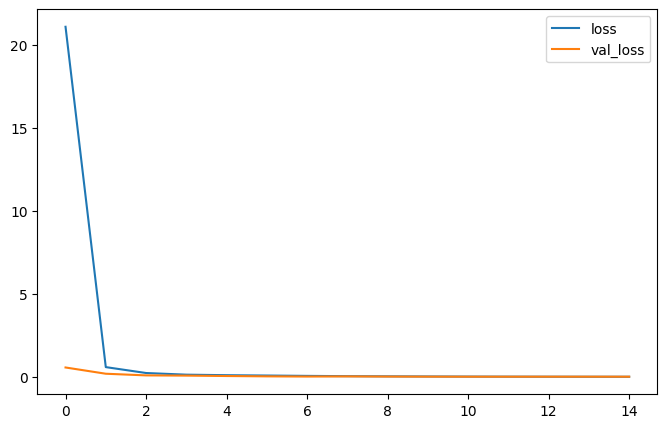

In [ ]:
pd.DataFrame(controlHistory.history)[['loss','val_loss']].plot(figsize=(8,5))

In [ ]:
controlModel.evaluate(X_test, y_test)

891/891 [==============================] - 3s 3ms/step - loss: 0.0101 - sparse_categorical_accuracy: 0.9985


[0.01009655836969614, 0.9985253214836121]

In [ ]:
predictions = controlModel.predict(X_test)
y_pred = np.argmax(predictions, axis=-1) # Take the highest likelihood and convert into our test

891/891 [==============================] - 1s 2ms/step


In [ ]:
f1_score(y_pred, y_test)

0.6612903225806451

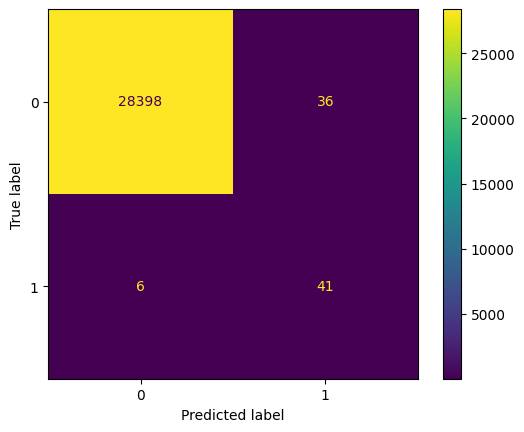

In [ ]:
confusionMatrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
displayConfusionMatrix = ConfusionMatrixDisplay(confusionMatrix)
displayConfusionMatrix.plot()

<h1/>Control Model Results</h1>

Our FNN achieved an F1 score of X. There were X false negatives and X false positives to achieve X true positives.
</br></br>
This would be 

<h1/>Tabular Transformer Model</h1>

The next model will be a tabular transformer, and the goal is to beat the control model in every characteristic, but particularly XYZ 

In [ ]:
numericFeatures = list(df[df.columns.drop('Class')].columns.values)
categoricalFeatures = []

In [ ]:
trainDF = pd.DataFrame.join(X_train, y_train) # rejoining because module requires datasets which have y_train as a target rather than a separate array
trainDF.columns = [column[0] if type(column) != str else column for column in trainDF.columns] # renaming columns because joining on the index causes the left side to convert to tuples containing the column name

validDF = pd.DataFrame.join(X_valid, y_valid) # manually repeating the process
validDF.columns = [column[0] if type(column) != str else column for column in trainDF.columns]

testDF = pd.DataFrame.join(X_test, y_test)
testDF.columns = [column[0] if type(column) != str else column for column in trainDF.columns]

In [ ]:
features = list(numericFeatures) + list(categoricalFeatures)
label = 'Class'

train_dataset = df_to_dataset(trainDF[features + [label]], label, shuffle=False, batch_size=8192) # batch size as large as possible before failure
val_dataset = df_to_dataset(validDF[features + [label]], label, shuffle=False, batch_size=8192)
test_dataset = df_to_dataset(testDF[features + [label]], shuffle=False, batch_size=8192)

/usr/local/lib/python3.9/dist-packages/tabtransformertf/utils/preprocessing.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]
/usr/local/lib/python3.9/dist-packages/tabtransformertf/utils/preprocessing.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]
/usr/local/lib/python3.9/dist-packages/tabtransformertf/utils/preprocessing.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]


In [ ]:
FTencoder = FTTransformerEncoder(
    numerical_features = numericFeatures,
    categorical_features = categoricalFeatures,
    numerical_data = trainDF[numericFeatures].values,
    categorical_data = None,
    y = y_train.values,
    numerical_embedding_type='linear', # 
    embedding_dim=32,  # required to make this actually run
    depth=2,
    heads=15,
    attn_dropout=0.1,
    ff_dropout=0.1,
    explainable=False
)

tabTransformerModel = FTTransformer(
    encoder = FTencoder,
    out_dim = 1,
    out_activation = "sigmoid"

)

tabTransformerModel.compile(  # compile with same hyperparameters
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), 
    loss = tf.keras.losses.BinaryCrossentropy(), 
    metrics=['sparse_categorical_accuracy']
    )

In [ ]:
tabTransformerHistory = tabTransformerModel.fit(train_dataset, validation_data=val_dataset, epochs=5)

Epoch 1/5
25/25 [==============================] - 31s 639ms/step - loss: 0.3418 - sparse_categorical_accuracy: 0.7692 - val_loss: 7.2315 - val_sparse_categorical_accuracy: 0.9982
Epoch 2/5
25/25 [==============================] - 16s 630ms/step - loss: 0.9503 - sparse_categorical_accuracy: 0.7692 - val_loss: 1.5128 - val_sparse_categorical_accuracy: 0.9982
Epoch 3/5
25/25 [==============================] - 16s 636ms/step - loss: 1.1107 - sparse_categorical_accuracy: 0.7692 - val_loss: 0.5291 - val_sparse_categorical_accuracy: 0.9982
Epoch 4/5
25/25 [==============================] - 16s 637ms/step - loss: 0.7802 - sparse_categorical_accuracy: 0.7692 - val_loss: 0.4735 - val_sparse_categorical_accuracy: 0.9982
Epoch 5/5
25/25 [==============================] - 18s 707ms/step - loss: 0.6378 - sparse_categorical_accuracy: 0.7692 - val_loss: 0.3741 - val_sparse_categorical_accuracy: 0.9982


<Axes: >

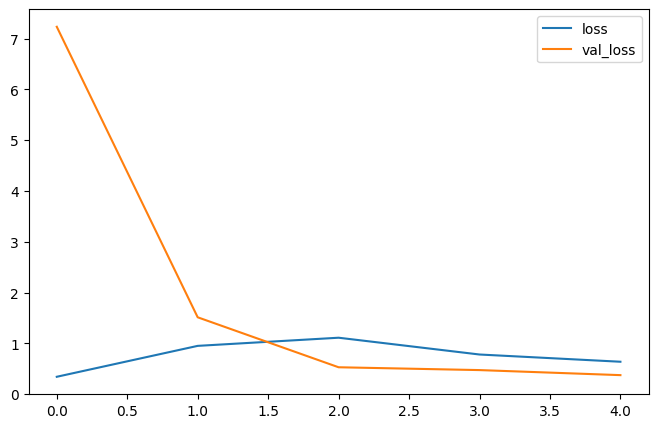

In [ ]:
pd.DataFrame(tabTransformerHistory.history)[['loss','val_loss']].plot(figsize=(8,5))

In [ ]:
tabPredictions = tabTransformerModel.predict(test_dataset)

4/4 [==============================] - 2s 220ms/step


In [ ]:
tab_y_pred = [int(round(x[0])) for x in tabPredictions]

In [ ]:
f1_score(tab_y_pred, y_test)

0.0

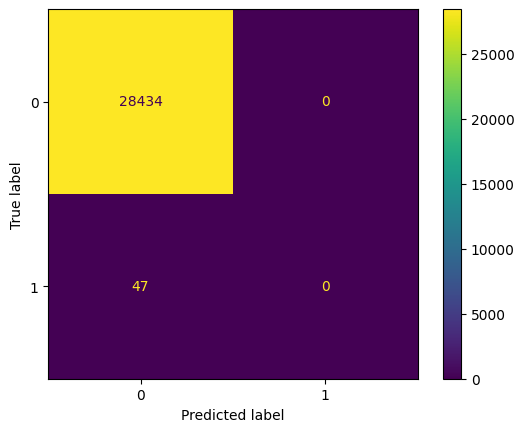

In [ ]:
confusionMatrix = confusion_matrix(y_true=y_test, y_pred=tab_y_pred)
displayConfusionMatrix = ConfusionMatrixDisplay(confusionMatrix)
displayConfusionMatrix.plot()

In [ ]:
FTencoder_2 = FTTransformerEncoder(
    numerical_features = numericFeatures,
    categorical_features = categoricalFeatures,
    numerical_data = trainDF[numericFeatures].values,
    categorical_data = None,
    y = y_train.values,
    numerical_embedding_type='linear', # 
    embedding_dim=32,  # required to make this actually run
    depth=4,
    heads=6,
    attn_dropout=0.1,
    ff_dropout=0.1,
    explainable=False
)

tabTransformerModel_2 = FTTransformer(
    encoder = FTencoder_2,
    out_dim = 1,
    out_activation = "sigmoid"

)

tabTransformerModel_2.compile(  # compile with same hyperparameters
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), 
    loss = tf.keras.losses.BinaryCrossentropy(), 
    metrics=['sparse_categorical_accuracy']
    )

In [ ]:
tabTransformerHistory_2 = tabTransformerModel_2.fit(train_dataset, validation_data=val_dataset, epochs=5)

Epoch 1/5
25/25 [==============================] - 43s 726ms/step - loss: 0.3849 - sparse_categorical_accuracy: 0.7692 - val_loss: 6.6419 - val_sparse_categorical_accuracy: 0.9982
Epoch 2/5
25/25 [==============================] - 17s 661ms/step - loss: 1.5940 - sparse_categorical_accuracy: 0.7692 - val_loss: 0.6779 - val_sparse_categorical_accuracy: 0.9982
Epoch 3/5
25/25 [==============================] - 15s 595ms/step - loss: 0.9827 - sparse_categorical_accuracy: 0.7692 - val_loss: 0.7164 - val_sparse_categorical_accuracy: 0.9982
Epoch 4/5
25/25 [==============================] - 15s 592ms/step - loss: 0.9282 - sparse_categorical_accuracy: 0.7692 - val_loss: 0.3992 - val_sparse_categorical_accuracy: 0.9982
Epoch 5/5
25/25 [==============================] - 20s 779ms/step - loss: 0.6604 - sparse_categorical_accuracy: 0.7692 - val_loss: 0.6219 - val_sparse_categorical_accuracy: 0.9982


<Axes: >

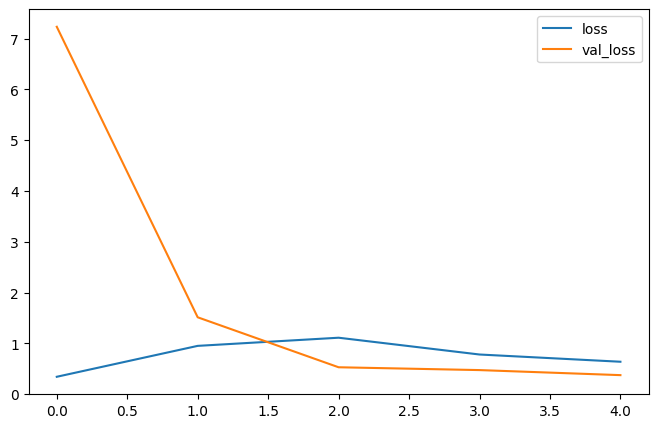

In [ ]:
pd.DataFrame(tabTransformerHistory.history)[['loss','val_loss']].plot(figsize=(8,5))

In [ ]:
tabPredictions_2 = tabTransformerModel.predict(test_dataset)
tab_y_pred_2 = [int(round(x[0])) for x in tabPredictions]

f1_score(tab_y_pred_2, y_test)

4/4 [==============================] - 1s 222ms/step


0.0

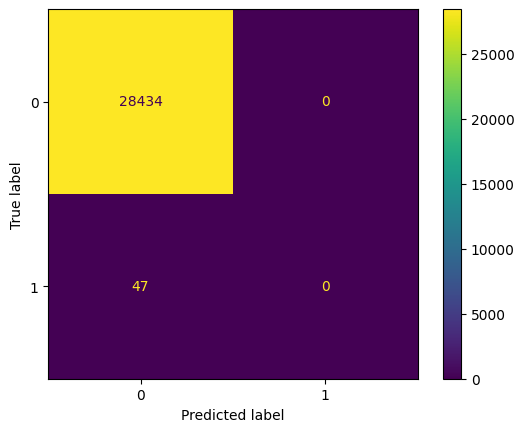

In [ ]:
confusionMatrix = confusion_matrix(y_true=y_test, y_pred=tab_y_pred_2)
displayConfusionMatrix = ConfusionMatrixDisplay(confusionMatrix)
displayConfusionMatrix.plot()

In [ ]:
periodicEncoder = FTTransformerEncoder(
    numerical_features = numericFeatures,
    categorical_features = categoricalFeatures,
    numerical_data = trainDF[numericFeatures].values,
    categorical_data = None,
    y = y_train.values,
    numerical_embedding_type='periodic',
    numerical_bins=128,
    embedding_dim=64,
    depth=3,
    heads=6,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=False
)

# Pass th encoder to the model
periodicTabTransformerModel = FTTransformer(
    encoder=periodicEncoder,
    out_dim=1,
    out_activation="sigmoid",
)

periodicTabTransformerModel.compile(  # compile with same hyperparameters
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), 
    loss = tf.keras.losses.BinaryCrossentropy(), 
    metrics=['sparse_categorical_accuracy']
    )

In [ ]:
periodicTabTransformerHistory = periodicTabTransformerModel.fit(train_dataset, validation_data=val_dataset, epochs=5)

Epoch 1/5
25/25 [==============================] - 38s 800ms/step - loss: 0.5477 - sparse_categorical_accuracy: 0.7692 - val_loss: 5.8600 - val_sparse_categorical_accuracy: 0.9982
Epoch 2/5
25/25 [==============================] - 20s 795ms/step - loss: 0.9955 - sparse_categorical_accuracy: 0.7692 - val_loss: 5.8347 - val_sparse_categorical_accuracy: 0.9982
Epoch 3/5
25/25 [==============================] - 20s 778ms/step - loss: 2.1197 - sparse_categorical_accuracy: 0.7692 - val_loss: 0.5983 - val_sparse_categorical_accuracy: 0.9982
Epoch 4/5
25/25 [==============================] - 19s 772ms/step - loss: 0.9028 - sparse_categorical_accuracy: 0.7692 - val_loss: 0.6067 - val_sparse_categorical_accuracy: 0.9982
Epoch 5/5
25/25 [==============================] - 21s 765ms/step - loss: 0.7189 - sparse_categorical_accuracy: 0.7692 - val_loss: 0.5157 - val_sparse_categorical_accuracy: 0.9982


<Axes: >

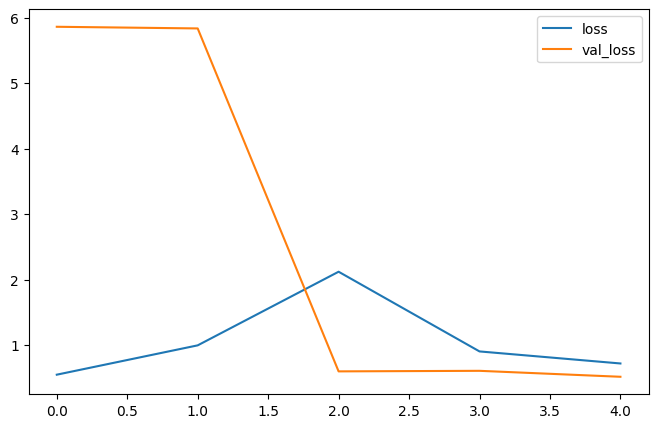

In [ ]:
pd.DataFrame(periodicTabTransformerHistory.history)[['loss','val_loss']].plot(figsize=(8,5))

In [ ]:
periodicPredictions = periodicTabTransformerModel.predict(test_dataset)
per_y_pred = [int(round(x[0])) for x in tabPredictions]

f1_score(per_y_pred, y_test)

4/4 [==============================] - 2s 245ms/step


0.0

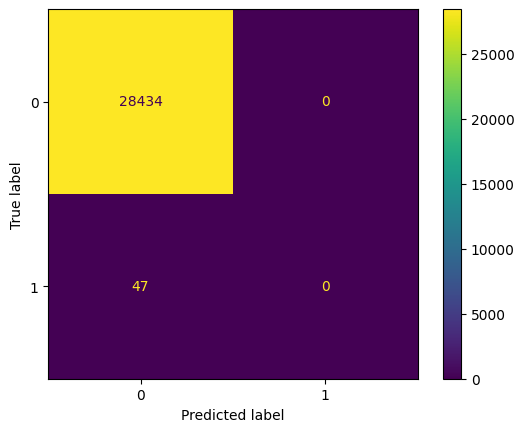

In [ ]:
confusionMatrix = confusion_matrix(y_true=y_test, y_pred=per_y_pred)
displayConfusionMatrix = ConfusionMatrixDisplay(confusionMatrix)
displayConfusionMatrix.plot()

None of the transformer models have managed to detect the minority class. The baseline neural network functioned adequately, yet all the transformer models have the same problem: their output does not get altered by loss, they are effectively not learning. The FT-transformer, or feature-tokenizer transformer adds a CLS token. My hypothesis is that with so few fraud cases, they likely share few, if any common features. Additionally, there is not much data and training takes an exceptionally long time.

The likely cause of this is nature of the dataset. While the features are anonymized, there is a good chance they're completely unrelated. The result is that the model is treating each vector as a sentence when what it needs to look for is an aberrant "word". 